# Gradient Descent for Linear and Logistic Regression

In [14]:
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from itertools import islice

plt.style.use('ggplot')

## Example: Simple Linear Regression.

In [15]:
x_linear = np.random.uniform(-1, 1, 250)
y_linear = 1 - 2.0 * x_linear + np.random.normal(0, 1.5, 250)

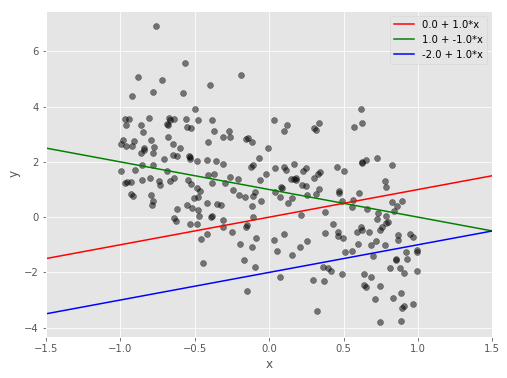

In [16]:
fig, ax = plt.subplots(1, figsize=(8, 6))
ax.scatter(x_linear, y_linear, c='k', alpha=0.5)

lines = [
    ((0, 1), "red"),
    ((1, -1), "green"),
    ((-2, 1), "blue")
]

xs = np.linspace(-1.5, 1.5, 250)
for coefficients, color in lines:
    ax.plot(xs, coefficients[0] + coefficients[1]*xs, color=color,
            label="{:1.1f} + {:1.1f}*x".format(*coefficients))
ax.set_xlim(-1.5, 1.5)
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y');

In [17]:
def ordinary_linear_model_cost(y, y_hat):
    return np.sum((y - y_hat)**2)

In [18]:
def linear_pred(x, beta_0 , beta_1):
    return beta_0 + beta_1*x

In [19]:
def cost_grid(x, y, cost_func, pred_fun, 
              b0_lim=(-2.5, 2.5), b1_lim=(-2.5, 2.5)):
    intercepts, coefs = (
        np.linspace(b0_lim[0], b0_lim[1], 250),
        np.linspace(b1_lim[0], b1_lim[1], 250))
    costs = np.zeros((250, 250))
    for i, intercept in enumerate(intercepts):
        for j, coef in enumerate(coefs):
            costs[i, j] = cost_func(y, pred_fun(x, intercept, coef))
    return intercepts, coefs, costs

In [20]:
def cost_contour_plot(ax, x, y, cost_func, pred_fun, 
                      b0_lim=(-2.5, 2.5), b1_lim=(-2.5, 2.5)):
    intercepts, coefs, costs = cost_grid(x, y, cost_func, pred_fun, b0_lim, b1_lim)
    contour = ax.contour(
        intercepts, coefs, costs, 12, cmap=cm.gray
    )
    ax.clabel(contour, fontsize=9, inline=1)
    return ax

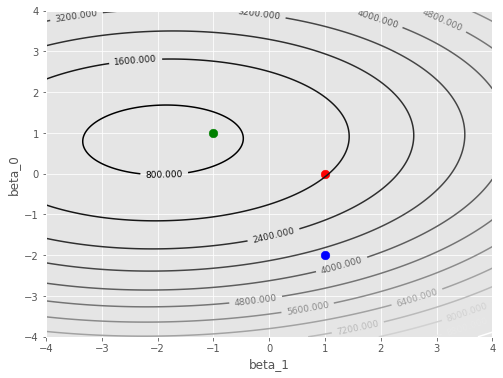

In [21]:
fig, ax = plt.subplots(1, figsize=(8, 6))
cost_contour_plot(ax, x_linear, y_linear, 
                            ordinary_linear_model_cost,
                            linear_pred,
                            (-4, 4), (-4, 4))
for coefficients, color in lines:
    ax.scatter([coefficients[1]], [coefficients[0]], s=75, color=color)
    
ax.set_xlabel('beta_1')
ax.set_ylabel('beta_0');

## Example: Simple Logistic Regression.

In [22]:
def pred_proba(x, beta_0, beta_1):
    return 1 / (1 + np.exp(-(beta_0 + beta_1*x)))

In [23]:
x_logistic = np.random.uniform(-2, 2, 250)
y_logistic = np.random.binomial(1, pred_proba(x_logistic, 0, 3))

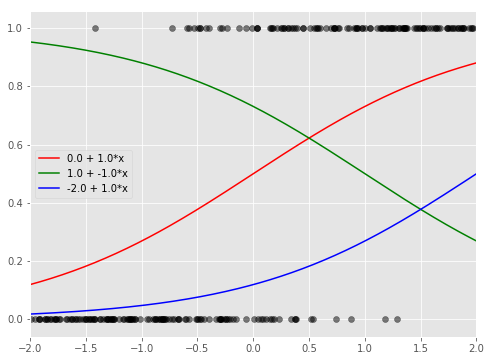

In [24]:
fig, ax = plt.subplots(1, figsize=(8, 6))
ax.scatter(x_logistic, 
           y_logistic,
           c='k', alpha=0.5)

lines = [
    ((0, 1), "red"),
    ((1, -1), "green"),
    ((-2, 1), "blue")
]

xs = np.linspace(-2, 2, 250)
for coefs, color in lines:
    ax.plot(xs, pred_proba(xs, coefs[0], coefs[1]), color=color,
            label="{:1.1f} + {:1.1f}*x".format(*coefs))
ax.set_xlim(-2.0, 2.0)
ax.legend();

In [25]:
def simple_logistic_model_log_likelihood(y, prob):
    return - np.sum(y * np.log(prob) + (1 - y)*np.log(1 - prob))

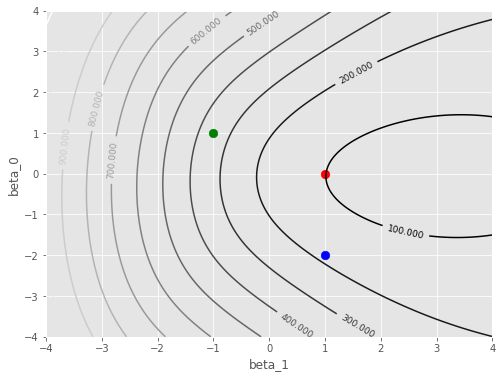

In [27]:
fig, ax = plt.subplots(1, figsize=(8, 6))
cost_contour_plot(ax, x_logistic, y_logistic, 
                            simple_logistic_model_log_likelihood,
                            pred_proba, (-4, 4), (-4, 4))
for coefficients, color in lines:
    ax.scatter([coefficients[1]], [coefficients[0]], s=75, color=color)
ax.set_xlabel('beta_1')
ax.set_ylabel('beta_0');

### Gradient Descent for a Linear Model

In [28]:
def linear_model_gradient(intercept, slope, x, y):
    return np.array([
        -2*np.sum(y - intercept - slope*x),
        -2*np.sum((y - intercept - slope*x)*x)
    ])

In [29]:
def simple_model_gradient_descent(gradient_func, initial_point, lam, x, y):
    current_point = initial_point
    current_gradient = gradient_func(current_point[0], current_point[1], x, y)
    while True:
        yield current_point, current_gradient
        current_point = current_point - lam * current_gradient
        current_gradient = gradient_func(current_point[0], current_point[1], x, y)

In [30]:
learning_rate = .001
initial_point = np.array([-3, 3])
linear_descent_path = simple_model_gradient_descent(
    linear_model_gradient, initial_point, 
    learning_rate, x_linear, y_linear)

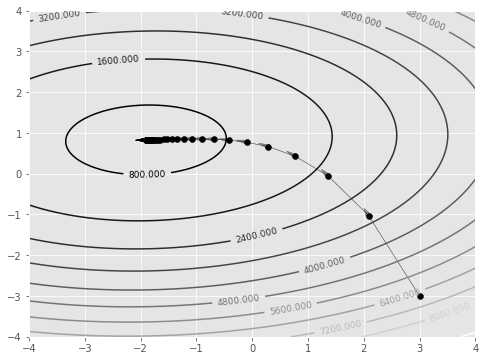

In [34]:
fig, ax = plt.subplots(1, figsize=(8, 6))
cost_contour_plot(ax, x_linear, y_linear, 
                            ordinary_linear_model_cost,
                            linear_pred,
                            (-4, 4), (-4, 4))
gradient_descent_path = list(islice(linear_descent_path, 35))
for i, ((intercept, slope), gradient) in enumerate(gradient_descent_path):
    #print(0.001*gradient)
    ax.scatter([slope], [intercept], color="black")
    ax.arrow(
        slope, intercept,
        -learning_rate*gradient[1], -learning_rate*gradient[0],
        color="black",
        head_width=0.1, head_length=0.2,
        alpha=0.4
    )

### Gradient Descent for a Logistic Model

In [36]:
def logistic_model_gradient(intercept, coef, x, y):
    return np.array([
        -np.sum(y - pred_proba(x, intercept, coef)),
        -np.sum((y - pred_proba(x, intercept, coef))*x)
    ])

In [37]:
learning_rate = .01
initial_point = np.array([-3, 3])
logistic_descent_path = simple_model_gradient_descent(
    logistic_model_gradient, initial_point, 
    learning_rate, x_logistic, y_logistic)

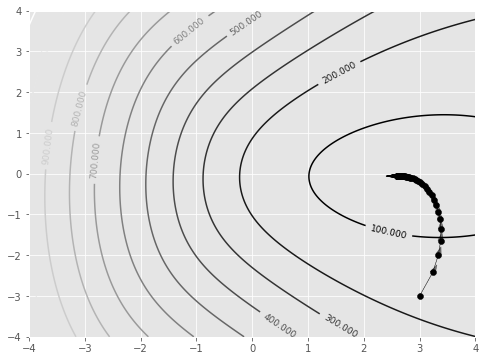

In [39]:
fig, ax = plt.subplots(1, figsize=(8, 6))
cost_contour_plot(ax, x_logistic, y_logistic, 
                            simple_logistic_model_log_likelihood,
                            pred_proba,
                            (-4, 4), (-4, 4))
gradient_descent_path = list(islice(logistic_descent_path, 50))
for i, ((intercept, slope), gradient) in enumerate(gradient_descent_path):
    #print(0.001*gradient)
    ax.scatter([slope], [intercept], color="black")
    ax.arrow(
        slope, intercept,
        -learning_rate*gradient[1], -learning_rate*gradient[0],
        color="black",
        head_width=0.1, head_length=0.2,
        alpha=0.5
    )

### Stochastic Gradient Descent for Linear Model

In [40]:
def linear_model_stochastic_gradient(intercept, slope, x, y):
    random_idx = np.random.choice(x.shape[0])
    x, y = x[random_idx], y[random_idx]
    return np.array([
        -(y - intercept - slope*x),
        -(y - intercept - slope*x)*x
    ])

In [41]:
learning_rate = .01
initial_point = np.array([-3, 3])
linear_descent_path = simple_model_gradient_descent(
    linear_model_stochastic_gradient, initial_point, 
    learning_rate, x_linear, y_linear)

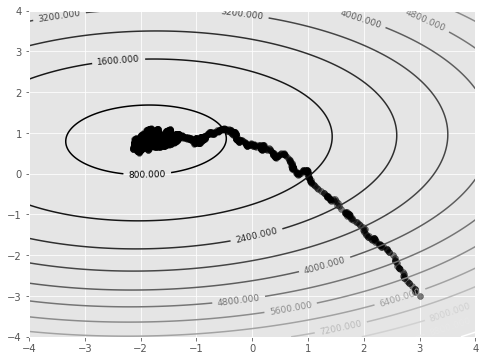

In [43]:
fig, ax = plt.subplots(1, figsize=(8, 6))
cost_contour_plot(ax, x_linear, y_linear, 
                            ordinary_linear_model_cost,
                            linear_pred,
                            (-4, 4), (-4, 4))
gradient_descent_path = list(islice(linear_descent_path, 5000))
for i, ((intercept, slope), gradient) in enumerate(gradient_descent_path):
    ax.scatter([slope], [intercept], color="black", alpha=0.5)

### Stochastic Gradient Descent for Logistic Model

In [44]:
def logistic_model_stochastic_gradient(intercept, coef, x, y):
    random_idx = np.random.choice(x.shape[0])
    x, y = x[random_idx], y[random_idx]
    return np.array([
        -(y - pred_proba(x, intercept, coef)),
        -((y - pred_proba(x, intercept, coef))*x)
    ])

In [45]:
learning_rate = .01
initial_point = np.array([-3, 3])
logistic_descent_path = simple_model_gradient_descent(
    logistic_model_stochastic_gradient, initial_point, 
    learning_rate, x_logistic, y_logistic)

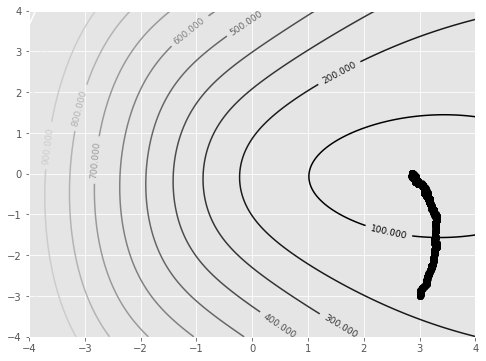

In [46]:
fig, ax = plt.subplots(1, figsize=(8, 6))
cost_contour_plot(ax, x_logistic, y_logistic, 
                            simple_logistic_model_log_likelihood,
                            pred_proba,
                            (-4, 4), (-4, 4))
gradient_descent_path = list(islice(logistic_descent_path, 5000))
for i, ((intercept, slope), gradient) in enumerate(gradient_descent_path):
    #print(0.001*gradient)
    ax.scatter([slope], [intercept], color="black")